In [1]:
import sys
import os

In [2]:
curr_dir = sys.path[0]

src_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))
main_dir = os.path.abspath(os.path.join(src_dir, os.pardir))
notebooks_dir = os.path.join(main_dir, 'notebooks')

In [3]:
sys.path

['/home/baambriz/q2_code/src/analysis',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/home/baambriz/.local/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages/IPython/extensions',
 '/home/baambriz/.ipython']

TODO:  Using the checkpoints to load the models used and return output to be visualized

In [4]:
import numpy as np
import pandas as pd

# loading q1 results

### Fully Connected NN

In [64]:
fcnn_predictions = pd.read_csv(main_dir + '/fcnn_predictions.csv', index_col = False)

In [65]:
fcnn_predictions.shape

(1451, 4)

In [70]:
fcnn_predictions.head()

,hbb_prediction,qcd_prediction,hbb_label,qcd_label
0,0.565156,0.434844,0.0,1.0
1,0.756909,0.243091,0.0,1.0
2,0.878706,0.121294,1.0,0.0
3,0.827727,0.172273,1.0,0.0
4,0.995768,0.004232,1.0,0.0


### Deep Sets NN

In [67]:
dsnn_predictions = pd.read_csv(main_dir + '/dsnn_predictions.csv', index_col=False)

In [68]:
dsnn_predictions.shape

(1451, 4)

In [69]:
dsnn_predictions.head()

,hbb_prediction,qcd_prediction,hbb_label,qcd_label
0,0.395396,0.604604,0.0,1.0
1,0.529054,0.470946,0.0,1.0
2,0.866197,0.133803,1.0,0.0
3,0.790758,0.209242,1.0,0.0
4,0.910616,0.089384,1.0,0.0


# loading q2 results

### Graph NN 

In [49]:
graph_predictions = pd.read_csv(main_dir + '/GENConv_predictions.csv', index_col=False)

In [50]:
graph_predictions.shape

(1889, 2)

In [51]:
graph_predictions = graph_predictions.iloc[:len(dsnn_predictions),:]

In [71]:
graph_predictions.head()

,hbb_prediction,hbb_label
0,-8.443853,0
1,-14.679830,0
2,-5.623161,0
3,-7.973312,0
4,-9.264545,0


## Evaluation / Comparison

### Graph of AUC

In [63]:
dsnn_predictions

,hbb_prediction,qcd prediction,hbb_label,qcd_label
0,0.356889,0.643111,0.0,1.0
1,0.412856,0.587144,0.0,1.0
2,0.808863,0.191137,1.0,0.0
3,0.662966,0.337034,1.0,0.0
4,0.933967,0.066033,1.0,0.0
...,...,...,...,...
1446,0.930072,0.069928,1.0,0.0
1447,0.913461,0.086539,1.0,0.0
1448,0.745517,0.254483,0.0,1.0
1449,0.352504,0.647496,1.0,0.0


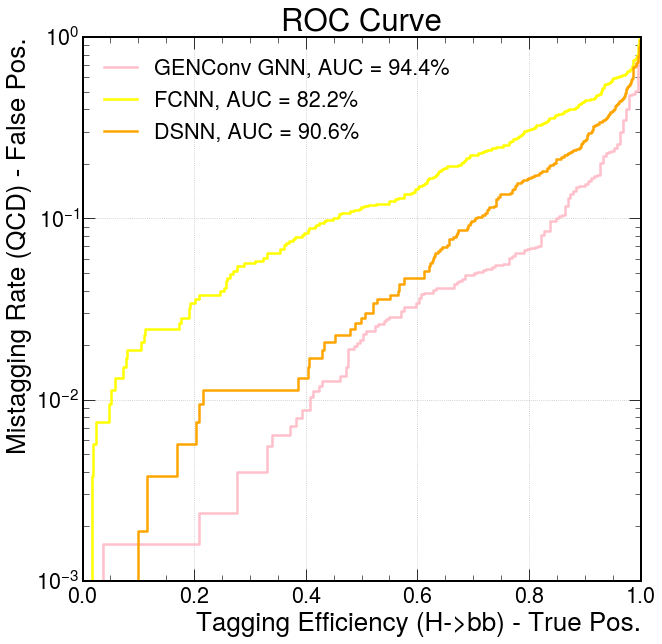

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(graph_predictions['hbb_label'], graph_predictions['hbb_prediction'])
fpr_fcnn, tpr_fcnn, threshold_fcnn = roc_curve(fcnn_predictions['hbb_label'], fcnn_predictions['hbb_prediction'] )
fpr_dsnn, tpr_dsnn, threshold_dsnn = roc_curve(dsnn_predictions['hbb_label'], dsnn_predictions['hbb_prediction'])
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GENConv GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), c = 'pink')
plt.plot(tpr_fcnn, fpr_fcnn, lw=2.5, label="FCNN, AUC = {:.1f}%".format(auc(fpr_fcnn,tpr_fcnn)*100), c = 'yellow')
plt.plot(tpr_dsnn, fpr_dsnn, lw=2.5, label="DSNN, AUC = {:.1f}%".format(auc(fpr_dsnn,tpr_dsnn)*100), c = 'orange')
plt.xlabel(r'Tagging Efficiency (H->bb) - True Pos.')
plt.ylabel(r'Mistagging Rate (QCD) - False Pos.')
plt.title('ROC Curve')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

### Graph of ROC using DDT Procedure

In [112]:
sys.path.insert(0, os.path.realpath('../../config'))

In [113]:
sys.path

['/home/baambriz/q2_code/config',
 '/home/baambriz/q2_code/src/analysis',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/home/baambriz/.local/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages',
 '/opt/conda/lib/python3.9/site-packages/IPython/extensions',
 '/home/baambriz/.ipython']

In [115]:
from utils import find_nearest

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

In [117]:
#DDT Procedure
cutoff = 0.01
idx_gnn, val_gnn = find_nearest(fpr_gnn, cutoff)
idx_fcnn, val_fcnn = find_nearest(fpr_fcnn, cutoff)
idx_dsnn, val_dsnn = find_nearest(fpr_dsnn, cutoff)
label_test_gnn_ddt = graph_predictions['hbb_label'] * (graph_predictions['hbb_prediction'] > threshold_gnn[idx_gnn])
label_test_fcnn_ddt = fcnn_predictions['hbb_label'] * (fcnn_predictions['hbb_prediction'] > threshold_fcnn[idx_fcnn])
label_test_dsnn_ddt = dsnn_predictions['hbb_label'] * (dsnn_predictions['hbb_prediction'] > threshold_dsnn[idx_dsnn])

fpr_gnn_ddt, tpr_gnn_ddt, threshold_gnn_ddt = roc_curve(label_test_gnn_ddt, graph_predictions['hbb_prediction'])
fpr_fcnn_ddt, tpr_fcnn_ddt, threshold_fcnn_ddt = roc_curve(label_test_fcnn_ddt, fcnn_predictions['hbb_prediction'])
fpr_dsnn_ddt, tpr_dsnn_ddt, threshold_dsnn_ddt = roc_curve(label_test_dsnn_ddt, dsnn_predictions['hbb_prediction'])


In [121]:
import yaml

with open('../../config/definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [122]:
from DataGenerator import DataGenerator
# load testing file
test_files = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_0.root']
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=8192, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True,
                               return_spectators=True,
                               max_entry=8192) # basically, no maximum

In [124]:
from tqdm.notebook import tqdm

In [126]:
# run model inference on test data set
predict_array_adv = []
label_array_test = []
spec_array_test = []

for t in tqdm(test_generator, total=len(test_generator)):
    label_array_test.append(t[1][0])
    spec_array_test.append(t[1][1])
    break

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
plt.figure()
for wp in [0.01]:
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights= label_array_test[:, 0] * (predict_array_adv[:,0] > threshold_adv[idx_adv]),
             alpha=0.4, density=True, color = 'red',label='Adversarial Network DDT, {}% FPR cut'.format(int(wp*100)),histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=predict_array_adv[:,1],
             alpha=0.4, density=True, color = 'blue',label='Adversarial Network, {}% FPR cut'.format(int(wp*100)), histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test[:,0],
             alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
    plt.title("Background Jet Mass Distribution")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (QCD)')
plt.xlim(40, 200)

plt.figure()
for wp in [0.01]:
    idx, val = find_nearest(fpr_adv, wp)
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test_adv_ddt,
             alpha=0.4, density=True, color='red', label='Adversarial Network DDT, {}% FPR cut'.format(int(wp*100)),histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=predict_array_adv[:,0],
             alpha=0.4, density=True, color = 'blue',label='Adversarial Network, {}% FPR cut'.format(int(wp*100)), histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test[:,1],
             alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
    plt.title("Signal Jet Mass Distribution")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (H-> bb)')
plt.xlim(40, 200)
plt.show()